# Basic examples

In this notebook we will show how to fit a model to data, in the **desilike** framework.
You need to have installed **desilike** with:
```
python -m pip install git+https://github.com/cosmodesi/desilike#egg=desilike
```
You also need to have installed:
```
python -m pip install iminuit zeus
```
And for analytic solver:
```
python -m pip install jax[cpu]
```

## Model
Let us define a simple, affine model.

In [1]:
from desilike.base import BaseCalculator


class AffineModel(BaseCalculator):  # all calculators should inherit from BaseCalculator

    # Model parameters; those can also be declared in a yaml file
    params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}},
              'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}
    
    def initialize(self, x=None):
        # Actual, non-trivial initialization must happen in initialize(); this is to be able to do AffineModel(x=...)
        # without doing any actual work
        self.x = x
    
    def calculate(self, a=0., b=0.):
        self.y = a * self.x + b  # simple, affine model
    
    # Not mandatory, this is to return something in particular after calculate (else this will just be the instance)
    def get(self):
        return self.y
    
    # This is only needed for emulation
    def __getstate__(self):
        return {'x': self.x, 'y': self.y}  # dictionary of Python base types and numpy arrays

## Likelihood

Let us define a Gaussian likelihood.

In [2]:
import numpy as np

from desilike.likelihoods import BaseLikelihood


class Likelihood(BaseLikelihood):
    
    def initialize(self, theory=None):
        # Let us generate some fake data
        self.x = np.linspace(0., 1., 10)
        mean = np.zeros_like(self.x)
        self.covariance = np.eye(len(self.x))
        self.precision = np.linalg.inv(self.covariance)
        rng = np.random.RandomState(seed=42)
        self.y = rng.multivariate_normal(mean, self.covariance)
        # Requirements
        # AffineModel will be instantied with AffineModel(x=self.x)
        if theory is None:
            theory = AffineModel()
        self.theory = theory
        self.theory.update(x=self.x)  # we set x-coordinates, they will be passed to AffineModel's initialize
    
    @property
    def flatdiff(self):
        # Requirements (theory, requested in __init__) are accessed through .name
        # The pipeline will make sure theory.run(a=..., b=...) has been called
        return self.y - self.theory.y  # data - model
    
    def calculate(self):
        self.loglikelihood = -0.5 * self.flatdiff.dot(self.precision).dot(self.flatdiff)  # this attribute must be named loglikelihood

## Pipeline
Let us initialize our likelihood pipeline, that connects the two calculators above.

In [3]:
from desilike import setup_logging

setup_logging()  # set up logging

likelihood = Likelihood()
likelihood.runtime_info.pipeline.calculators

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [4]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000000.15] [0/1] 11-21 10:23  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


In [5]:
profiles = profiler.profiles
# Quantities can be accessed through:
print(profiles.bestfit['a'])

# Save/load example
import os
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    profiles.save(fn)
    from desilike.samples import Profiles
    profiles = Profiles.load(fn)

print(profiles.to_stats(tablefmt='pretty'))

[-0.05917982 -0.05917978 -0.05917988 -0.0591798  -0.05917981]
[000000.44] [0/1] 11-21 10:23  Profiles                  INFO     Saving /tmp/tmpvz2q62oo/tmp.npy.
[000000.44] [0/1] 11-21 10:23  Profiles                  INFO     Loading /tmp/tmpvz2q62oo/tmp.npy.
+-------------+--------+---------+-------+
| chi2 = 4.70 | varied | bestfit | error |
+-------------+--------+---------+-------+
|      a      |  True  |  -0.06  | 0.98  |
|      b      |  True  |  0.48   | 0.58  |
+-------------+--------+---------+-------+


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

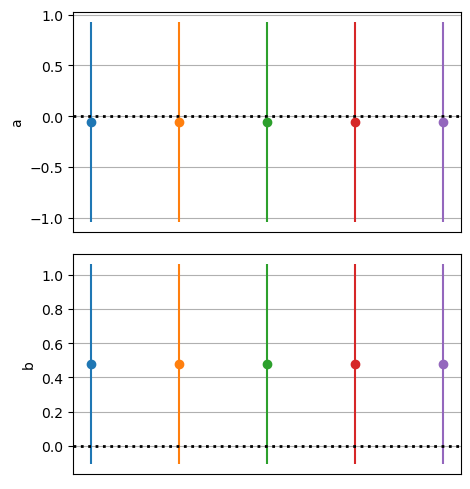

In [6]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiles, truths=[0., 0.])

In [7]:
# Compute \Delta \chi^{2} = cl^2 = 1 interval for the best best of above best fits
profiler.interval(cl=1)
# Interval can be accessed through
profiler.profiles.interval['a']
print(profiler.profiles.to_stats(tablefmt='latex_raw'))

\begin{tabular}{lllll}
\hline
 $\chi^{2} = 4.70$   & varied   & bestfit   & error   & interval             \\
\hline
 a                   & True     & $-0.06$   & $0.98$  & ${}_{-0.98}^{+0.98}$ \\
 b                   & True     & $0.48$    & $0.58$  & ${}_{-0.58}^{+0.58}$ \\
\hline
\end{tabular}


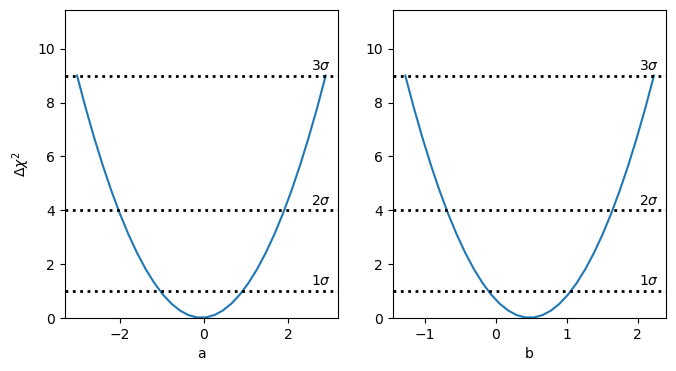

In [8]:
# Profile posterior up to cl = 3 sigmas
profiler.profile(cl=3)
# And plot, subtracting \chi^{2} at best fit
plotting.plot_profile(profiler.profiles, offsets=-2 * profiler.profiles.bestfit.logposterior.max())

## Analytic solver
If jax is installed (maybe we will provide an alterative relying on numpy only?), one can perform analytic marginalization over the parameters for which the model is linear.

In [9]:
from desilike.utils import jnp  # jax.numpy
from matplotlib import pyplot as plt


class AffineModelJax(AffineModel):  # all calculators should inherit from BaseCalculator (or another calculator)

    def initialize(self, x=None):
        self.x = jnp.array(x)


class LikelihoodWithPlot(Likelihood):

    # Just add a plotting routine
    def plot(self):
        ax = plt.gca()
        ax.errorbar(self.x, self.y, yerr=np.diag(self.covariance)**0.5, color='k', linestyle='none', marker='o', label='data')
        ax.plot(self.x, self.theory.y, color='r', label='theory')
        ax.grid()
        ax.legend()
        return ax

    
model = AffineModelJax()
# Specify we want to analytical solve for parameter 'b'
# 'derived' can be '.best' (fixed to best fit), '.marg' (analytic marginalization)
# or '.auto', which will be 'best' in case of likelihood profiling, 'marg' in case of sampling
model.params['b'].derived = '.auto'
likelihood = LikelihoodWithPlot(theory=model)

profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000002.05] [0/1] 11-21 10:23  absl                      INFO     Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
[000002.05] [0/1] 11-21 10:23  absl                      INFO     Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000002.05] [0/1] 11-21 10:23  absl                      INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
[000002.05] [0/1] 11-21 10:23  absl                      INFO     Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
[000002.05] [0/1] 11-21 10:23  absl                      WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
[000002.06] [0/1] 11-21 10:23  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


array([<AxesSubplot:ylabel='a'>], dtype=object)

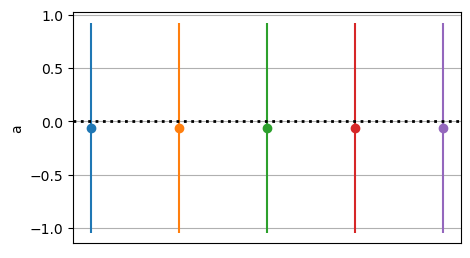

In [10]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiler.profiles, truths=[0., 0.])

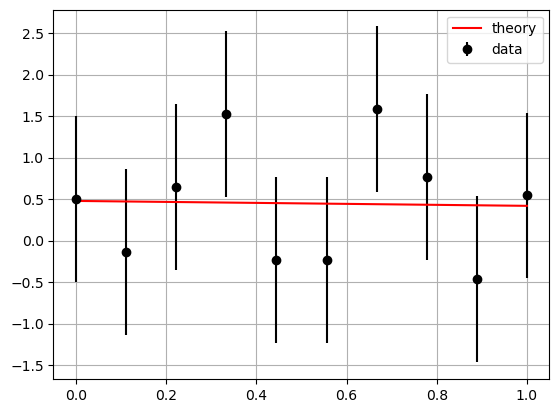

In [11]:
likelihood(**profiler.profiles.bestfit.choice(varied=True))
likelihood.plot()
plt.show()

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [12]:
from desilike.samplers import ZeusSampler

likelihood = LikelihoodWithPlot()

# By default are running 1 chain
# We can as for me, e.g. chains=2
# MPI processes will be evenly split across all the chains
sampler = ZeusSampler(likelihood, seed=42, nwalkers=10)
# We run samples until convergence, considered reached when Gelman-Rubin (computed over 4 chain subsamples) stabilizes < 0.03; 
sampler.run(check={'max_eigen_gr': 0.03})

[000003.94] [0/1] 11-21 10:23  ZeusSampler               INFO     Varied parameters: ['a', 'b'].
[000004.03] [0/1] 11-21 10:23  root                      INFO     Initialising ensemble of 10 walkers...
[000019.03] [0/1] 11-21 10:23  ZeusSampler               INFO     Diagnostics:
[000019.04] [0/1] 11-21 10:23  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is -0.000636; < 0.03.
[000019.05] [0/1] 11-21 10:23  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is -0.000645.
[000019.06] [0/1] 11-21 10:23  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0819.
[000019.07] [0/1] 11-21 10:23  ZeusSampler               INFO     - max Geweke is 0.324.
[000019.07] [0/1] 11-21 10:23  ZeusSampler               INFO     - Geweke p-value is 0.71.
[000019.08] [0/1] 11-21 10:23  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) (reliable) is 55.6.
[000019.10] [0/1] 11-21 10:23  root                    

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000036.92] [0/1] 11-21 10:24  ZeusSampler               INFO     Diagnostics:
[000036.93] [0/1] 11-21 10:24  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0293; < 0.03.
[000036.94] [0/1] 11-21 10:24  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00488.
[000036.95] [0/1] 11-21 10:24  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0194.
[000036.96] [0/1] 11-21 10:24  ZeusSampler               INFO     - max Geweke is 0.191.
[000036.96] [0/1] 11-21 10:24  ZeusSampler               INFO     - Geweke p-value is 0.332.
[000036.97] [0/1] 11-21 10:24  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) (reliable) is 110.
[000036.97] [0/1] 11-21 10:24  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.0294.


In [13]:
# If we want more samples, we can repeat run() calls, e.g.:
sampler.run(max_iterations=200)

[000036.99] [0/1] 11-21 10:24  root                      INFO     Initialising ensemble of 10 walkers...


In [14]:
# Let's remove burnin and get basic stats
chain = sampler.chains[0].remove_burnin(0.5)

# Save/load example
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    chain.save(fn)
    from desilike.samples import Chain
    chain = Chain.load(fn)

print(chain.to_stats(tablefmt='pretty'))

[000048.25] [0/1] 11-21 10:24  Chain                     INFO     Saving /tmp/tmprojsbryb/tmp.npy.
[000048.25] [0/1] 11-21 10:24  Chain                     INFO     Loading /tmp/tmprojsbryb/tmp.npy.
+---+--------+-------+--------+------+-----------------+-----------------+
|   | argmax | mean  | median | std  | quantile:1sigma | interval:1sigma |
+---+--------+-------+--------+------+-----------------+-----------------+
| a | -0.04  | -0.01 | -0.01  | 0.96 |   -0.96/+0.95   |   -0.94/+0.96   |
| b |  0.47  | 0.44  |  0.45  | 0.57 |   -0.58/+0.57   |   -0.56/+0.58   |
+---+--------+-------+--------+------+-----------------+-----------------+


[000048.31] [0/1] 11-21 10:24  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


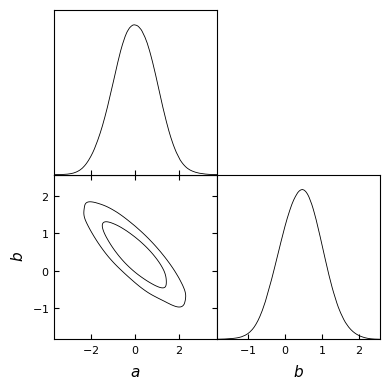

In [15]:
# This actually uses GetDist
# chain.to_getdist() will return a getdist.MCSamples object to play further
plotting.plot_triangle(chain)

## Emulate
If our model took years to run, we would likely want to emulate it. Let us try this on this simple model.

False
[000048.98] [0/1] 11-21 10:24  Emulator                  INFO     Varied parameters: ['a', 'b'].
[000048.98] [0/1] 11-21 10:24  Emulator                  INFO     Found varying ['y'] and fixed ['x'] outputs.
[000048.99] [0/1] 11-21 10:24  Emulator                  INFO     Diagnostics:
[000049.10] [0/1] 11-21 10:24  Emulator                  INFO     - mse of y is 0 (square root = 0).


[array([<AxesSubplot:ylabel='y'>, <AxesSubplot:ylabel='$\\Delta$ y'>],
       dtype=object)]

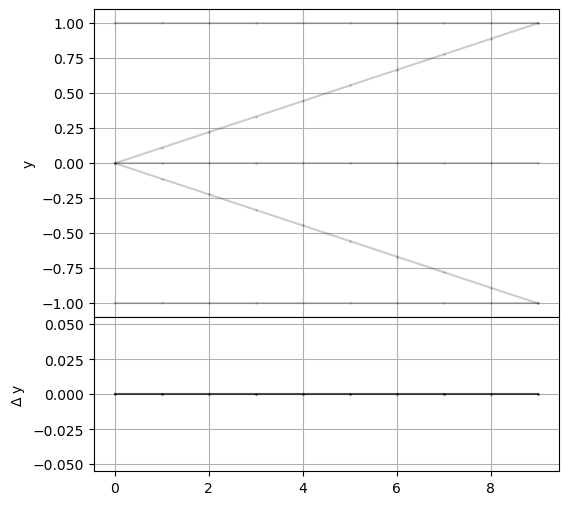

In [16]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

# Let's take the calculator we want to emulate, i.e. theory (AffineModel)
# Let us perform a Taylor expansion of order 1 for all attributes
# Attributes of AffineModel instance, obtained through theory.__getstate__()
# are automatically split between varied and fixed categories

likelihood = LikelihoodWithPlot()
likelihood()
print(likelihood.theory.params['b'].derived)

emulator = Emulator(likelihood.theory, engine=TaylorEmulatorEngine(order=1))
emulator.set_samples()
emulator.fit()
emulator.check()  # since model is linear, non-zero mse is just due to numerical noise
emulator.plot()  # plot some theory.y samples, and the difference emulator - model at the bottom; all good!

In [17]:
# Now dump the emulator to disk
base_dir = '_tests'
fn = os.path.join(base_dir, 'emulator.npy')
emulator.save(fn)

[000049.28] [0/1] 11-21 10:24  Emulator                  INFO     Saving _tests/emulator.npy.
[000049.28] [0/1] 11-21 10:24  BaseConfig                INFO     Saving _tests/emulator.yaml.


In [18]:
# A yaml file is exported, which helps recollect the parameters of the emulator
# The parameters that have been varied should be specified when using this emulator,
# other parameters (fixed) can be removed if necessary
with open(fn.replace('.npy', '.yaml')) as file:
    print(file.read())

class: AffineModel
info: {}
params:
  a:
    derived: false
    drop: false
    fixed: false
    latex: None
    namespace: ''
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    saved: true
    value: 0.0
  b:
    derived: false
    drop: false
    fixed: false
    latex: None
    namespace: ''
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    saved: true
    value: 0.0



In [19]:
# Now let us load our emulator into the pipeline
likelihood = Likelihood(theory=EmulatedCalculator.load(fn))  # or if the emulator is in memory, theory=emulator.to_calculator()

[000049.31] [0/1] 11-21 10:24  Emulator                  INFO     Loading _tests/emulator.npy.


[000049.34] [0/1] 11-21 10:24  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


array([<AxesSubplot:ylabel='a'>], dtype=object)

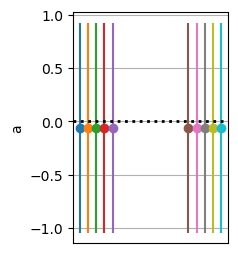

In [20]:
profiler2 = MinuitProfiler(likelihood, seed=42)
profiler2.maximize(niterations=5)
plotting.plot_aligned_stacked([profiler2.profiles, profiler.profiles], truths=True)  # truths=True will get parameter values
# Fits with the emulator and the model are the same, all good!